# 선린인터넷고등학교 데이터와 머신러닝 프로젝트 EDA 과제
team: 보채지마 자살하면 그만이야~~~~
2024년 11월 27일 제출


자살한 분들의 마지막 SNS를 조사, 분석하여 text 마이닝을 통한 자살 예방을 실시한다.

In [1]:
!pip install tensorflow pandas matplotlib konlpy seaborn koreanize_matplotlib scikit-learn transformers torch
import koreanize_matplotlib  


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install gdown 
!gdown 1lcyPfJjbFIKzKajrKyBluzf1KFEkOMMQ


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Downloading...
From (original): https://drive.google.com/uc?id=1lcyPfJjbFIKzKajrKyBluzf1KFEkOMMQ
From (redirected): https://drive.google.com/uc?id=1lcyPfJjbFIKzKajrKyBluzf1KFEkOMMQ&confirm=t&uuid=229bd87b-047a-44e9-93dc-5aff451f8bfb
To: /Users/compy/Documents/Projects/DataAndMachine/2024-/translated_data_backup_3000.csv
100%|████████████████████████████████████████| 169M/169M [00:04<00:00, 41.5MB/s]


# 데이터 전처리

```py
p = dataset_download("nikhileswarkomati/suicide-watch")
print(f"path: {p}")
move(f"{p}/Suicide_Detection.csv", "data.csv")
print("moved to data.csv")
```
이 코드로 data.csv 즉 인터넷에 있던 자살하기 전에 입력했던 SNS text 데이터들을 가져온 후 한국어 번역을 GPT-4-mini 모델로 의역을 하였습니다.
번역된 데이터를 따로 빼서 시각화하고 있습니다.

이후 데이터를 따로 이미 분리 및 classfication을 한 상태이기에 넘어가도 된다.(local에서 이미 처리한 데이터를 활용하고 있기 때문)

```
당신은 영어를 한국어로 번역하는 전문 번역가입니다. 
        다음 지침을 따라 번역해주세요:
        1. 직역보다는 한국어 화자가 자연스럽게 이해할 수 있도록 의역하세요.
        2. 인터넷 커뮤니티나 SNS의 문체를 반영해주세요.
        3. 이모지나 특수문자는 한국 인터넷 문화에 맞게 적절히 변환하세요.
        4. 은어나 속어는 한국의 상응하는 표현으로 바꿔주세요.
        5. 문맥상 생략된 내용이 있다면 자연스럽게 보완해주세요.
```
이러한 프롬프트로 번역을 진행함.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("translated_data_backup_3000.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   232074 non-null  int64 
 1   text         232074 non-null  object
 2   class        232074 non-null  object
 3   korean_text  3100 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.1+ MB
None
          Unnamed: 0
count  232074.000000
mean   174152.863518
std    100500.425362
min         2.000000
25%     87049.250000
50%    174358.500000
75%    261285.750000
max    348110.000000


/var/folders/qh/nphhp0ps7qq9h76_f25zqlww0000gn/T/ipykernel_62146/3359544338.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("translated_data_backup_3000.csv")


In [4]:
df = df[df['korean_text'].notna()][['korean_text', 'class']] 

df = df.rename(columns={'korean_text': 'text'})

df['class'] = df['class'].map({'suicide': True, 'non-suicide': False}) # 자살하면 True 아닌 경우 FALSE
df = df.reset_index(drop=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3100 non-null   object
 1   class   3100 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 27.4+ KB
None


In [5]:
df.head()

,text,class
0,"최근에 아내와 완전히 이별했어요. 그녀가 두 번이나 바람을 피우고, 거짓말을 너무 ...",True
1,"나 이상한 걸까? 현실에서 아는 사람한테 칭찬받아도 별로 기분이 안 좋은데, 인터넷...",False
2,"드디어 2020년이 거의 끝나가네... 이제 ""2020년은 나쁜 해였다""는 소리를 ...",False
3,"도와줘... 제발 도와줘, 너무 울고 있어... 😢",True
4,"너무 힘들어... 안녕하세요, 저는 아담(16세)이고, 몇 년 동안 힘든 시간을 보...",True


# 의문점 탐구

## 질문: 어떤 것들이 관계가 있을까? (기준 독립변수 찾아보기)

독립변수 탐색에 앞서서 어떤 것들이 있는지 나눠보겠다.

특정 단어 출현 빈도, 문장 구조 (짧은 문장 vs 긴 문장), 이모티콘/특수문자 사용, 긍정/부정 단어 사용 비율 
이렇게 4개로 나눠서 보도록 하겠다.

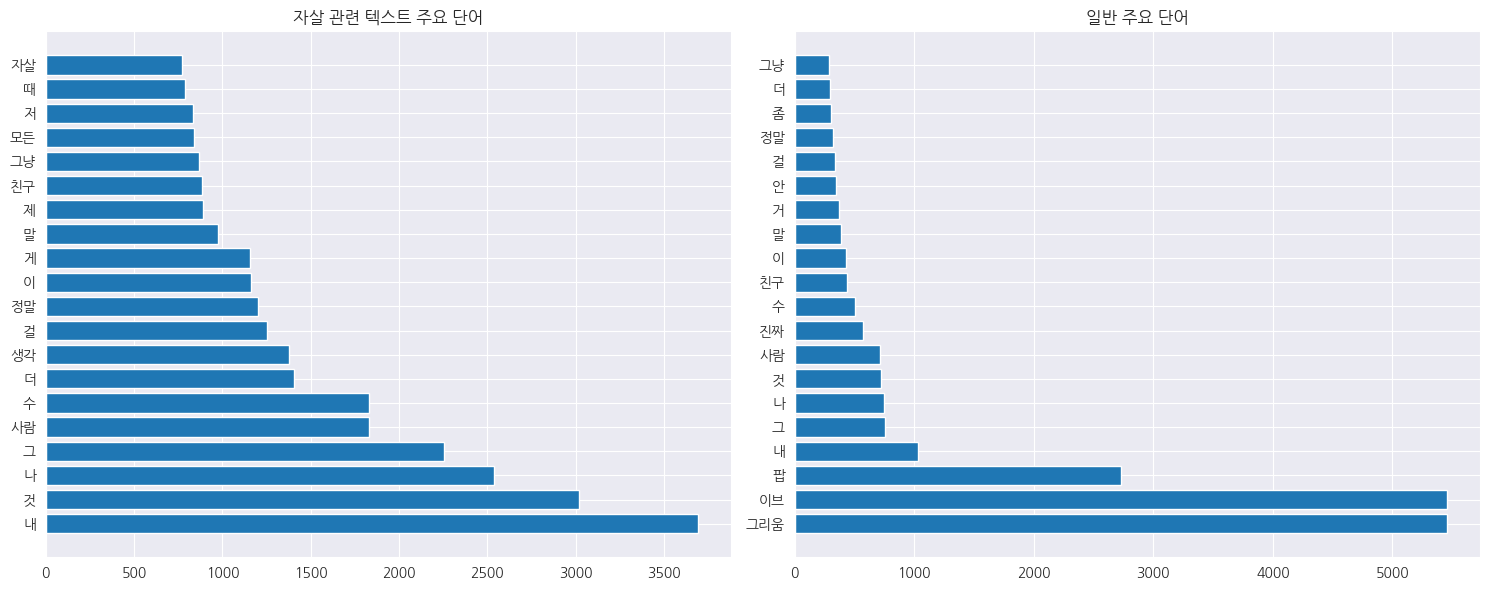

In [6]:
from collections import Counter
from konlpy.tag import Okt
import matplotlib.pyplot as plt


okt = Okt()

def get_word_freq(texts, top_n=20):
    words = []
    for text in texts:
        words.extend(okt.nouns(str(text)))
    return Counter(words).most_common(top_n)

true_words = get_word_freq(df[df['class'] == True]['text'])
false_words = get_word_freq(df[df['class'] == False]['text'])

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
words, counts = zip(*true_words)
plt.barh(words, counts)
plt.title('자살 관련 텍스트 주요 단어')

plt.subplot(1, 2, 2)
words, counts = zip(*false_words)
plt.barh(words, counts)
plt.title('일반 주요 단어')
plt.tight_layout()

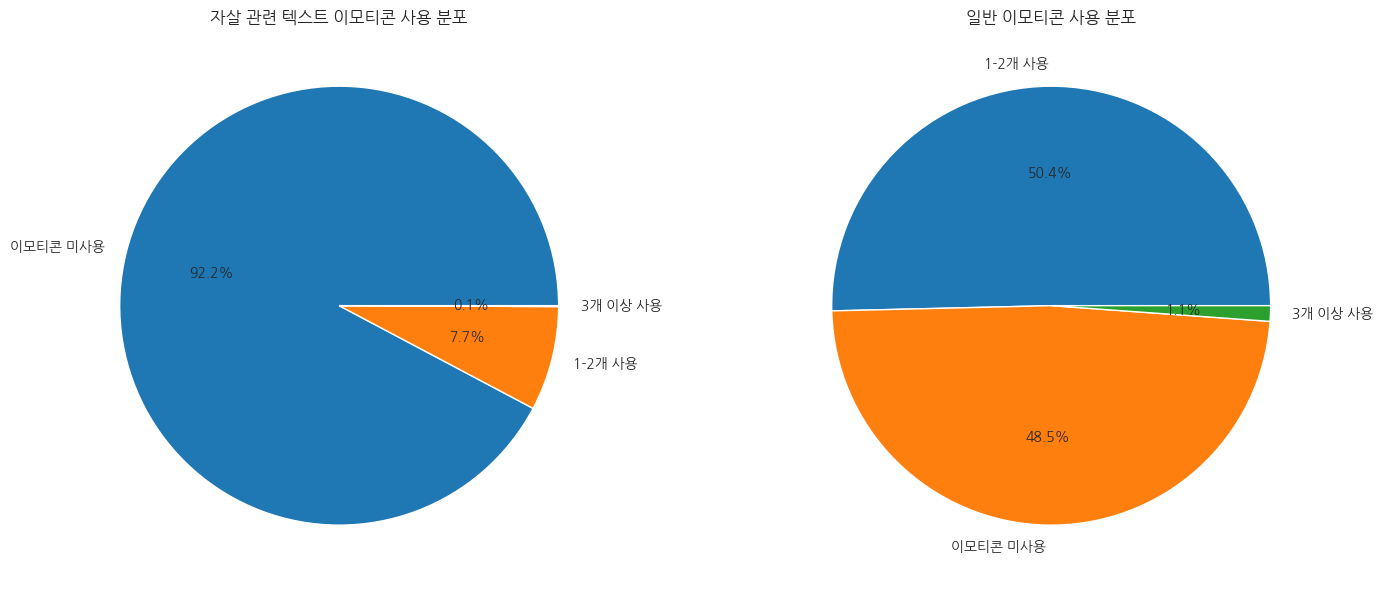

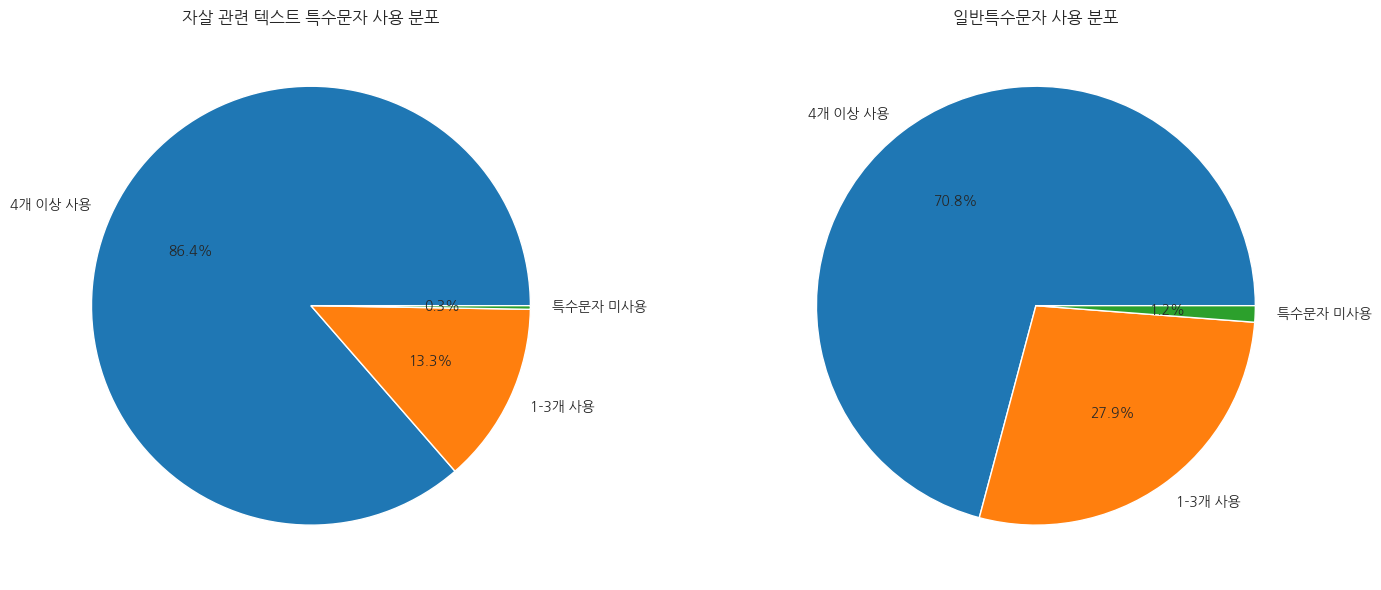

In [7]:
import re
import matplotlib.pyplot as plt

emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols, pictographs
        u'\U0001F680-\U0001F6FF'  # transport, map symbols
        u'\U0001F1E0-\U0001F1FF'  # iOS
        ']+', flags=re.UNICODE)
special_chars = re.compile('[!@#$%^&*(),.?":{}|<>]')

df['emoji_count'] = df['text'].apply(lambda x: len(emoji_pattern.findall(str(x))))
df['special_char_count'] = df['text'].apply(lambda x: len(special_chars.findall(str(x))))

def get_emoji_status(row):
    if row['emoji_count'] == 0:
        return '이모티콘 미사용'
    elif row['emoji_count'] <= 2:
        return '1-2개 사용'
    else:
        return '3개 이상 사용'

df['emoji_status'] = df.apply(get_emoji_status, axis=1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
suicide_emoji = df[df['class'] == True]['emoji_status'].value_counts()
plt.pie(suicide_emoji.values, labels=suicide_emoji.index, autopct='%1.1f%%')
plt.title('자살 관련 텍스트 이모티콘 사용 분포')

plt.subplot(1, 2, 2)
normal_emoji = df[df['class'] == False]['emoji_status'].value_counts()
plt.pie(normal_emoji.values, labels=normal_emoji.index, autopct='%1.1f%%')
plt.title('일반 이모티콘 사용 분포')

plt.tight_layout()

def get_special_char_status(row):
    if row['special_char_count'] == 0:
        return '특수문자 미사용'
    elif row['special_char_count'] <= 3:
        return '1-3개 사용'
    else:
        return '4개 이상 사용'

df['special_char_status'] = df.apply(get_special_char_status, axis=1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
suicide_special = df[df['class'] == True]['special_char_status'].value_counts()
plt.pie(suicide_special.values, labels=suicide_special.index, autopct='%1.1f%%')
plt.title('자살 관련 텍스트 특수문자 사용 분포')

plt.subplot(1, 2, 2)
normal_special = df[df['class'] == False]['special_char_status'].value_counts()
plt.pie(normal_special.values, labels=normal_special.index, autopct='%1.1f%%')
plt.title('일반특수문자 사용 분포')

plt.tight_layout()

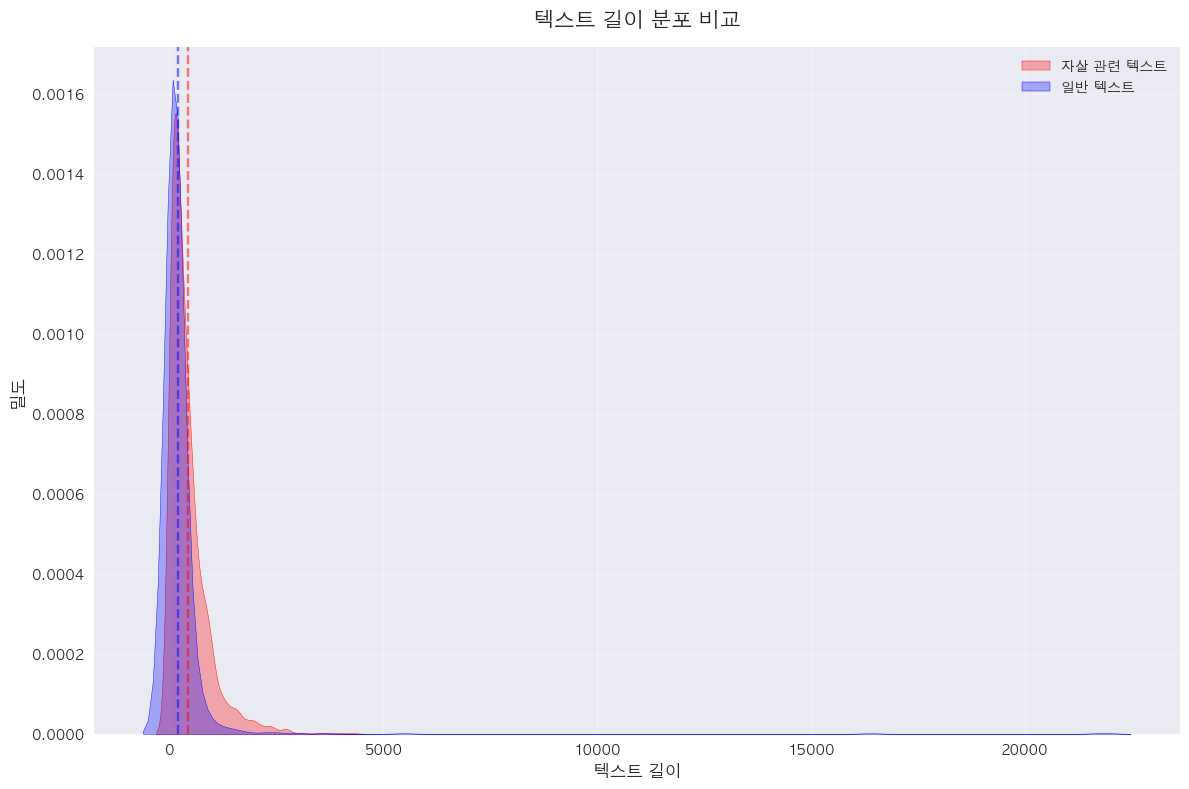

자살 관련 텍스트:
count    1522.000000
mean      425.586071
std       469.087554
min         8.000000
25%       119.000000
50%       282.500000
75%       555.000000
max      4246.000000
Name: text_length, dtype: float64
일반 텍스트:
count     1578.000000
mean       205.866920
std        917.875976
min         10.000000
25%         56.000000
50%         93.000000
75%        166.000000
max      21847.000000
Name: text_length, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib
import platform

plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 8))
plt.rcParams['axes.unicode_minus'] = False # 혹시 모를 상황에 대비해서
if platform.system() == 'Darwin': # 제가 MAC이여서...
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:  # 이거는 같이 프로젝트하는 친구가 linux...
    plt.rc('font', family='NanumGothic')
df['text_length'] = df['text'].str.len()

sns.kdeplot(data=df[df['class'] == True]['text_length'], 
            color='red', 
            label='자살 관련 텍스트',
            fill=True, 
            alpha=0.3)

sns.kdeplot(data=df[df['class'] == False]['text_length'], 
            color='blue', 
            label='일반 텍스트',
            fill=True, 
            alpha=0.3)

plt.title('텍스트 길이 분포 비교', fontsize=15, pad=15)
plt.xlabel('텍스트 길이', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.legend(fontsize=10)

plt.axvline(df[df['class'] == True]['text_length'].mean(), 
            color='red', 
            linestyle='--', 
            alpha=0.5, 
            label='자살 평균')
plt.axvline(df[df['class'] == False]['text_length'].mean(), 
            color='blue',
            linestyle='--',
            alpha=0.5,
            label='일반 평균')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("자살 관련 텍스트:")
print(df[df['class'] == True]['text_length'].describe())
print("일반 텍스트:")
print(df[df['class'] == False]['text_length'].describe())

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\n0에 가까울수록: 부정적인 감정 (슬픔, 우울, 분노 등)\n1에 가까울수록: 긍정적인 감정 (기쁨, 행복, 만족 등)\n0.5 주변: 중립적인 감정\n'

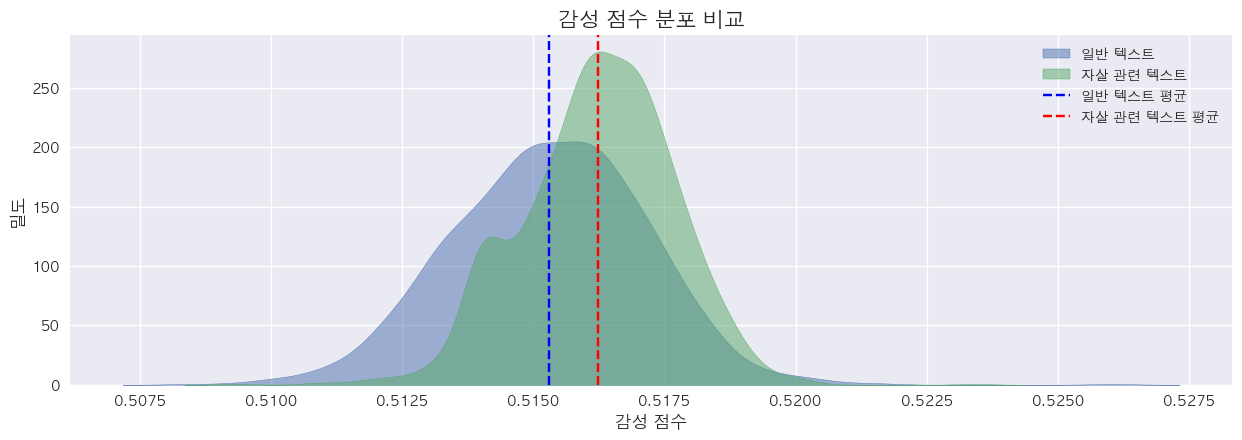

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# KoELECTRA 모델 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator")

def solution2(text, max_length=128):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    
    with torch.no_grad(): # 자원 낭비 ㄴㄴ
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        positive_score = predictions[:, 1].item()
    
    return positive_score

df['sentiment_score'] = df['text'].apply(solution2)
plt.style.use("seaborn-v0_8")

plt.figure(figsize=(15, 10))
if platform.system() == 'Darwin': # 제가 MAC이여서...
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:  # 이거는 같이 프로젝트하는 친구가 linux...
    plt.rc('font', family='NanumGothic')
plt.subplot(2, 1, 1)
sns.kdeplot(data=df[df['class'] == False]['sentiment_score'], 
            label='일반 텍스트', 
            fill=True, 
            alpha=0.5)
sns.kdeplot(data=df[df['class'] == True]['sentiment_score'], 
            label='자살 관련 텍스트', 
            fill=True, 
            alpha=0.5)
plt.axvline(df[df['class'] == False]['sentiment_score'].mean(), 
            color='blue', 
            linestyle='--', 
            label='일반 텍스트 평균')
plt.axvline(df[df['class'] == True]['sentiment_score'].mean(), 
            color='red', 
            linestyle='--', 
            label='자살 관련 텍스트 평균')

plt.title('감성 점수 분포 비교', fontsize=15)
plt.xlabel('감성 점수', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.legend(fontsize=10)

"""
0에 가까울수록: 부정적인 감정 (슬픔, 우울, 분노 등)
1에 가까울수록: 긍정적인 감정 (기쁨, 행복, 만족 등)
0.5 주변: 중립적인 감정
"""


# 통계 결과 분석
1. 텍스트 길이
* 자살 관련 텍스트가 일반적으로 더 긴 경향을 보임 (400자 이상의 구간에서 빨간색 영역이 더 넓음)
2. 이모티콘/특수문자 사용
* 자살 관련 텍스트의 경우:
*   이모티콘 미사용이 92.2%
*   1-2개 사용이 7.7%
* 일반 텍스트의 경우:
*   이모티콘 사용 비율이 더 높음 (약 50%)
*   더 다양한 이모티콘 사용 패턴
3. 감성 점수(얼마나 그러한 단어 사용과 문맥인가? - 평균적으로)
* 자살 관련 텍스트가 약간 더 높은 감성 점수를 보이나, 차이가 매우 작음
4. 주요 단어 사용
* 자살 관련 텍스트는 '나', '너', '그', '수' 등 개인적이고 주관적인 단어가 많이 사용
* 일반 텍스트는 '그리고', '아는', '것' 등 더 객관적인 단어들이 사용





우리가 고려해 봐야할 것들이 나왔다.
우리는 프로젝트에서 3번을 제외하고 1, 2, 4번을 판단 기준으로 잡으려고 한다.

그래서 결론적으로 우리는 
1. 텍스트 길이의 급격한 증가
2. 이모티콘 사용 감소
3. 개인적/감정적 단어 사용 증가

이러한 패턴이 동시에 나타날 경우 등에 대해서 분석하고 판단하도록 프로젝트를 설계할 것이다.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# 환경 변수 설정
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class SuicideDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        # 데이터 유효성 검증
        assert len(self.texts) == len(self.labels), "텍스트와 라벨의 개수가 일치하지 않습니다."
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        if idx >= len(self.texts):
            raise IndexError(f"인덱스 {idx}가 데이터셋 크기를 초과했습니다.")
            
        try:
            text = str(self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx])
            label = int(self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx])
            
            if not text.strip():
                text = "빈 텍스트"
            
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
            
        except Exception as e:
            print(f"데이터 처리 중 오류 발생 (인덱스 {idx}): {str(e)}")
            print(f"문제의 텍스트: {text[:100]}...")
            raise

class DeepSuicidePreventionModel(nn.Module):
    def __init__(self, pretrained_model="monologg/koelectra-small-v3-discriminator"):
        super().__init__()
        try:
            self.bert = AutoModel.from_pretrained(pretrained_model)
        except Exception as e:
            print(f"학습 모델 로드 중 오류 발생: {e}")
            raise e
            
        self.emotion_layer = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.context_layer = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

    def forward(self, input_ids, attention_mask):
        try:
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            
            sequence_output = outputs.last_hidden_state
            pooled_output = sequence_output[:, 0, :]
            
            emotion_features = self.emotion_layer(pooled_output)
            context_features = self.context_layer(sequence_output.mean(dim=1))
            
            combined_features = torch.cat([emotion_features, context_features], dim=1)
            logits = self.classifier(combined_features)
            return logits
            
        except RuntimeError as e:
            print(f"Forward 중 오류 발생: {e}")
            raise e

def create_data_loaders(train_texts, train_labels, val_texts, val_labels, tokenizer, batch_size=16):
    try:
        train_dataset = SuicideDataset(train_texts, train_labels, tokenizer)
        val_dataset = SuicideDataset(val_texts, val_labels, tokenizer)
        
        num_workers = 0  # Windows에서는 0으로 설정
        
        # DataLoader 생성
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=False,
            collate_fn=None,  # 기본 collate_fn 사용
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=False,
        )
        
        return train_loader, val_loader
        
    except Exception as e:
        print(f"데이터 로더 생성 중 오류 발생: {str(e)}")
        raise

def train_model(model, train_loader, val_loader, device, num_epochs=5):
    try:
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        criterion = nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()
                except RuntimeError as e:
                    print(f"배치 처리 중 오류 발생: {e}")
                    continue
            
            train_accuracy = 100 * train_correct / train_total
            
            # Validation
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    try:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['label'].to(device)
                        
                        outputs = model(input_ids, attention_mask)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                    except RuntimeError as e:
                        print(f"검증 배치 처리 중 오류 발생: {e}")
                        continue
            
            val_accuracy = 100 * val_correct / val_total
            
            print(f'Epoch {epoch + 1}:')
            print(f'Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
            
            # 체크포인트 저장
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                print("최상의 모델이 저장되었습니다.")
                
    except Exception as e:
        print(f"학습 중 오류 발생: {e}")
        raise e

def main():
    print("프로그램을 초기화하는 중...")
    
    try:
        # CUDA 메모리 설정
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.backends.cudnn.benchmark = True
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"사용 중인 디바이스: {device}")
        
        # 데이터 로드
        df = pd.read_csv("translated_data_backup_3000.csv")
        
        # 결측치 처리
        df = df[df['korean_text'].notna()]
        df['korean_text'] = df['korean_text'].astype(str).apply(lambda x: x.strip())
        df = df[df['korean_text'] != '']
        
        # 레이블 변환
        df['class'] = df['class'].map({'suicide': 1, 'non-suicide': 0})
        
        # 데이터 분할
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            df['korean_text'],
            df['class'],
            test_size=0.2,
            random_state=42,
            stratify=df['class']  # 클래스 비율 유지
        )
        
        # 모델 및 토크나이저 초기화
        tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
        model = DeepSuicidePreventionModel().to(device)
        
        # 데이터 로더 생성
        train_loader, val_loader = create_data_loaders(
            train_texts,
            train_labels,
            val_texts,
            val_labels,
            tokenizer,
            batch_size=8  # 배치 사이즈 축소
        )
        
        print("모델 학습 시작...")
        train_model(model, train_loader, val_loader, device)
        print("모델 학습 완료!")
    except Exception as e:
        print(f"프로그램 실행 중 오류 발생: {str(e)}")
        print("스택 트레이스:")
        import traceback
        traceback.print_exc()
        return

if __name__ == "__main__":
    main()

프로그램을 초기화하는 중...
사용 중인 디바이스: cpu
모델 학습 시작...


Epoch 1/5:   5%|▌         | 16/310 [00:03<01:09,  4.26it/s]


KeyboardInterrupt: 

In [3]:
import torch
from transformers import AutoTokenizer
import pandas as pd
import os
import warnings
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def load_model(model_path, device):
    try:
        model = DeepSuicidePreventionModel().to(device)        
        checkpoint = torch.load(model_path, map_location=device)
        
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint: model.load_state_dict(checkpoint['model_state_dict'])
        else: model.load_state_dict(checkpoint)
            
        print("model loaded")
        return model
        
    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        raise

def analyze_text(text, model, tokenizer, device):
    try:
        model.eval()
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            risk_score = probabilities[0][1].item()
        
        return prediction.item(), risk_score
        
    except Exception as e:
        print(f"텍스트 분석 중 오류 발생: {e}")
        raise

def main():
    print("테스트 프로그램을 초기화하는 중...")
    
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"사용 중인 디바이스: {device}")
        
        model_path = 'best_model.pth'
        
        tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
        model = load_model(model_path, device)
        
        # 테스트 텍스트
        test_texts = [
            
        ]
        
        print("\n=== 테스트 시작 ===")
        
        for text in test_texts:
            try:
                prediction, risk_score = analyze_text(text, model, tokenizer, device)
                
                print("\n입력 텍스트:", text)
                print("-" * 55)
                print(f"판정: {'자살 위험 있음' if prediction == 1 else '일반 텍스트'}")
                print(f"위험도: {risk_score:.2%}")
                
                if prediction == 1 and risk_score > 0.7:
                    print("\n⚠️ 주의: 높은 수준의 위험이 감지되었습니다.")
                    print("자살예방상담전화 ☎ 1393")
                    print("정신건강상담전화 ☎ 1577-0199")
                    
            except Exception as e:
                print(f"텍스트 분석 중 오류 발생: {str(e)}")
                continue
        
        print("\n=== 대화형 테스트 모드 ===")
        
        while True:
            print("\n" + "="*50)
            text = input("분석할 텍스트를 입력하세요 (종료하려면 'q' 입력):\n")
            
            if text.lower() == 'q':
                break
                
            if not text.strip():
                print("텍스트를 입력해주세요.")
                continue
            
            try:
                prediction, risk_score = analyze_text(text, model, tokenizer, device)
                
                print("\n분석 결과:", end="")
                print(text)
                print("-" * 30)
                print(f"판정: {'자살 위험 있음' if prediction == 1 else '일반 텍스트'}")
                print(f"위험도: {risk_score:.2%}")
                
                if prediction == 1 and risk_score > 0.7:
                    print("\n⚠️ 주의: 높은 수준의 위험이 감지되었습니다.")
                    print("자살예방상담전화 ☎ 1393")
                    print("정신건강상담전화 ☎ 1577-0199")
                    
            except Exception as e:
                print(f"텍스트 분석 중 오류 발생: {str(e)}")
                continue
                
    except Exception as e:
        print(f"프로그램 실행 중 오류 발생: {str(e)}")
        print("스택 트레이스:")
        import traceback
        traceback.print_exc()
        return

if __name__ == "__main__":
    main()
    
    # F6APVYsrrFeoHJj

테스트 프로그램을 초기화하는 중...
사용 중인 디바이스: cpu
model loaded

=== 테스트 시작 ===

=== 대화형 테스트 모드 ===


분석 결과:안녕?
------------------------------
판정: 일반 텍스트
위험도: 44.72%


분석 결과:아오
------------------------------
판정: 일반 텍스트
위험도: 21.11%


분석 결과:죽고 싶어
------------------------------
판정: 자살 위험 있음
위험도: 94.85%

⚠️ 주의: 높은 수준의 위험이 감지되었습니다.
자살예방상담전화 ☎ 1393
정신건강상담전화 ☎ 1577-0199

텍스트를 입력해주세요.


분석 결과:1
------------------------------
판정: 일반 텍스트
위험도: 29.81%

